In [1]:
def recommendation(title):
    book = books_list.index(title)
    corr_book = corr_mat[book]
    corr_dataframe = pd.DataFrame({'books':books_list,'corr_book' : corr_book})
    images = (list(corr_dataframe[corr_dataframe['corr_book']>0.95].sort_values('corr_book',ascending=False)['books']))
    images = [item for item in images if item !=title]
    images = images[:10]
    images1 = images[:8]
    if len(images1) %2 != 0:
        images1 = images1[:-1]
    fig, ax = plt.subplots(nrows=round(len(images1)/2), ncols=2,figsize=(20,30))
    for i in range(len(images1)):
        URL = url.loc[images[i]][0]
        response = requests.get(URL)
        img = Image.open(BytesIO(response.content))
        plt.subplot(int(len(images1)/2), 2, (i+1))
        plt.axis('off')
        plt.title(images1[i],{'fontsize': 18, 'fontweight':'bold'})
        plt.imshow(img)
    plt.savefig('Poster',dpi=150)   
    for i in range(len(images)):
        print(images[i],'\t')

In [2]:
def verification(title):
    book = books_list.index(title)
    corr_book = corr_mat[book]
    corr_dataframe = pd.DataFrame({'books':books_list,'corr_book' : corr_book})
    corr_books = (list(corr_dataframe[corr_dataframe['corr_book']>0.50].sort_values('corr_book',ascending=False)['books']))
    corr_books = [item for item in corr_books if item !=title]
    corr_books = corr_books[:5]
    title_tag = list(final_books['tag_name'][final_books['title']== title])
    dictionary = {}
    accuracy = 0
    for i in range(len(corr_books)):
        dictionary[corr_books[i]] = set(list(final_books['tag_name'][final_books['title']==corr_books[i]]))
    for key, value in dictionary.items():
        title_tag = list(final_books['tag_name'][final_books['title']== title])
        count = 0
        for i in value:
            if i in title_tag:
                count=count+1
        #print(key, ' matches ', count/len(title_tag)*100,'% with ', title)
        accuracy = accuracy + count/len(title_tag)
    return ((accuracy/len(corr_books)))
        

In [3]:
def randomrecommendation(title):
    top_tag = list(final_books1[final_books1['title']==title].sort_values('count',ascending=False).head(1).tag_name)
    top_recommended = list(final_books1[final_books1['tag_name']==top_tag[0]].sort_values('count',ascending = False).title.head(5))
    top_recommended = [item for item in top_recommended if item !=title]
    print(top_recommended)
    

In [4]:
def randomrecommendationverification(title):
    top_tag = list(final_books1[final_books1['title']==title].sort_values('count',ascending=False).head(1).tag_name)
    top_recommended = list(final_books1[final_books1['tag_name']==top_tag[0]].sort_values('count',ascending = False).title.head(5))
    top_recommended = [item for item in top_recommended if item !=title]
    dictionary = {}
    accuracy = 0
    for i in range(len(top_recommended)):
        dictionary[top_recommended[i]] = set(list(final_books1['tag_name'][final_books1['title']==top_recommended[i]]))
    for key, value in dictionary.items():
        title_tag = set(list(final_books1['tag_name'][final_books1['title']== title]))
        count = 0
        for i in value:
            if i in title_tag:
                count=count+1
        #print(key, ' matches ', count/len(title_tag)*100,'% with ', title)
        accuracy = accuracy + count/len(title_tag)
    return ((accuracy/len(top_recommended)))

In [5]:
import pandas as pd
from pandas import Series, DataFrame
from sklearn.decomposition import TruncatedSVD
import numpy as np
import scipy.linalg as SL
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

In [6]:
books = pd.read_csv('books.csv')
del books['work_text_reviews_count']
del books['ratings_count']
del books['best_book_id']
del books['isbn13']
del books['isbn']
del books['original_title']
#english language only
lang = ['eng', 'en-US','en-GB','en-CA','en']
books= books[books['language_code'].isin(lang)]
url = books[['image_url','title']]
url = url.set_index('title')
del books['image_url']
del books['small_image_url']
del books['language_code']

In [7]:
tags = pd.read_csv('tags.csv')
book_tag= pd.read_csv('book_tags.csv')
book_tags = pd.merge(book_tag,tags,on='tag_id',how='left')
book_tags['values']=book_tags.groupby('tag_name')['tag_name'].transform('count')


In [8]:
book_tags = pd.merge(book_tag,tags,on='tag_id',how='left')
book_tags['values']=book_tags.groupby('tag_name')['tag_name'].transform('count')
book_tags=book_tags[~book_tags['tag_name'].str.contains(r'[^\x00-\x7F]+')]
book_tags=book_tags[book_tags['tag_name'].str.len() >2]
ml_book_tags = book_tags
tgs= ['erotica','historical-fiction','drama','historical','history','war','fantasy','young-adult', 'fiction','adventure', 'children', 'children-s', 'sci-fi-fantasy',
       'childhood','children-s-books', 'kids','fantasy-sci-fi','fantasy-sci-fi', 'ya-fantasy','teen', 
     'supernatural', 'mystery','ya-fiction','young-adult-fiction','women','mythology',
       'scifi-fantasy','romance', 'science-fiction-fantasy','fantasy-scifi', 'classic','action', 'sci-fi',
     'friendship', 'love', 'humor', 'contemporary-fiction', 'thriller','science-fiction', 'funny','action-adventure', 'scifi',
       'comedy', 'humour', 'adult', 'adult-fiction', 'literature', 'science','philosophy','history', 'nonfiction', 'non-fiction', 'historical',
     'family','drama', 'high-school', 'women','suspense','crime','erotica','religion', 'politics',
     'horror', 'crime', 'suspense', 'mystery-thriller','horror','paranormal','memoir',
       'memoirs', 'biography', 'biography-memoir', 'memoir-biography',
       'animals', 'autobiography', 'favorites', 'favorites', 'all-time-favorites', 'favorite-books', 'favorite', 'faves', 'my-favorites', 'favs',
       'thrillers', 'stand-alone', 'mysteries','mystery-crime', 'mystery-suspense', 'crime-mystery','suspense-thriller']
book_tags=book_tags[book_tags['tag_name'].isin(tgs)]
del book_tags['values']


In [9]:
scififantasy = 'sci-fi-fantasy fantasy-sci-fi science-fiction-fantasy fantasy-scifi scifi-fantasy'
scififantasy = scififantasy.split()
fiction = ['ya-fiction','fiction']
scifi = 'scifi science-fiction sci-fi'
scifi = scifi.split()
nonfiction = 'nonfiction non-fiction'
nonfiction = nonfiction.split()
children = 'children children-s children-s-books kids'
children = children.split()
crime_mystery = 'mystery-crime crime-mystery'
crime_mystery = crime_mystery.split()
mystery = ['mysteries', 'mystery']
thriller = ['thriller','thrillers']
humor = ['humor', 'humour']
novel =['novel','novels']
history = ['historical','history']
biography = ['memoir',
       'memoirs', 'biography', 'biography-memoir', 'memoir-biography',
       'animals', 'autobiography']
favorite = [ 'favorites', 'favorites', 'all-time-favorites', 'favorite-books', 'favorite', 'faves', 'my-favorites', 'favs']
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'scififantasy' if x in scififantasy else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'scifi' if x in scifi else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'nonfiction' if x in nonfiction else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'children' if x in children else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'crime_mystery' if x in crime_mystery else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'mystery' if x in mystery else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'thriller' if x in thriller else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'humor' if x in humor else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'fiction' if x in fiction else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'history' if x in history else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'biography' if x in biography else x)
book_tags['tag_name'] = book_tags['tag_name'].apply(lambda x: 'favorite' if x in favorite else x)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [10]:
final_books = pd.merge(books,book_tags,on='goodreads_book_id', how='left')
final_books.to_csv('Final Book .csv')
del final_books['goodreads_book_id']
del final_books['books_count']
del final_books['authors']
del final_books['tag_id']
del final_books['original_publication_year']
del final_books['work_id']
del final_books['book_id']
final_books.drop(['tag_name','count'],axis=1).drop_duplicates().to_csv('Final Book .csv')
del final_books['ratings_1']
del final_books['ratings_2']
del final_books['ratings_3']
del final_books['ratings_4']
del final_books['ratings_5']
del final_books['average_rating']

final_books1 = final_books.copy()
del final_books['count']
final_books = final_books.drop_duplicates()

In [11]:
final_pivot = final_books.pivot_table(columns=['tag_name'],
                                      index=['title'],
                                     fill_value=0,
                                     aggfunc='count')
final_pivot = pd.DataFrame(final_pivot['work_ratings_count'])
final_pivot = final_pivot.reset_index()
final_pivot=final_pivot.set_index('title')

In [12]:
SVD = TruncatedSVD(n_components=15,random_state=123)
resultant_matrix = SVD.fit_transform(final_pivot)
resultant_matrix.shape
corr_mat=np.corrcoef(resultant_matrix)

In [13]:
books_names = final_pivot.index
books_list = list(books_names)

In [ ]:
%time
comparison= pd.DataFrame()
comparison['title'] = final_books['title'].unique()
%time
comparison['acc'] = comparison['title'].apply(verification)
%time
comparison['randomacc'] = comparison['title'].apply(randomrecommendationverification)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


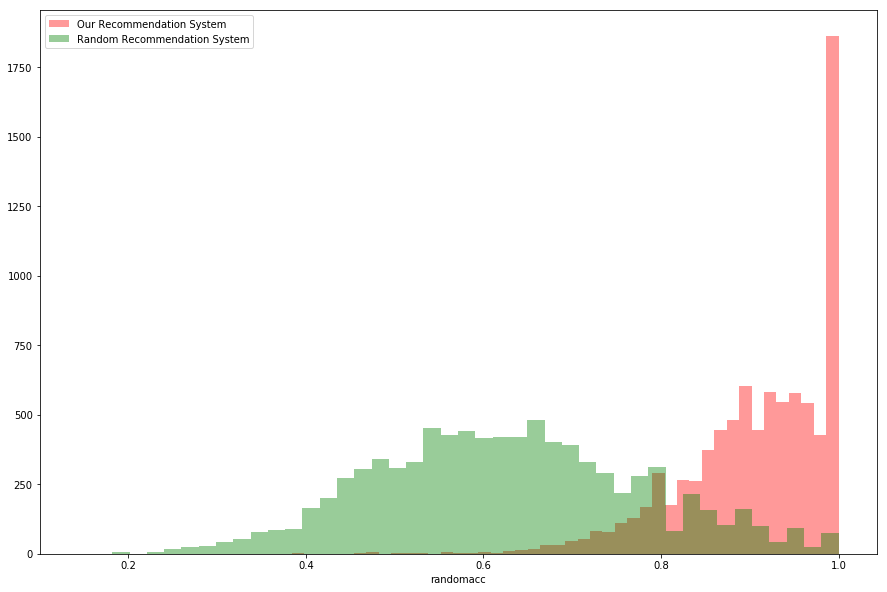

In [386]:
sns.distplot(comparison['acc'],kde=False, color='r',)
sns.distplot(comparison['randomacc'],kde=False,color='g')
fig = plt.gcf()
fig.set_size_inches(15, 10)

plt.legend(['Our Recommendation System','Random Recommendation System'])
plt.savefig('Poster2',dpi=150) 

In [14]:
select_list = []
for book in books_list:
    if 'Harry Potter' in book:
        select_list.append(book)
print(select_list)

['Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)', 'Harry Potter Boxset (Harry Potter, #1-7)', 'Harry Potter Collection (Harry Potter, #1-6)', 'Harry Potter Schoolbooks Box Set: Two Classic Books from the Library of Hogwarts School of Witchcraft and Wizardry', 'Harry Potter and the Chamber of Secrets (Harry Potter, #2)', 'Harry Potter and the Cursed Child - Parts One and Two (Harry Potter, #8)', 'Harry Potter and the Deathly Hallows (Harry Potter, #7)', 'Harry Potter and the Goblet of Fire (Harry Potter, #4)', 'Harry Potter and the Half-Blood Prince (Harry Potter, #6)', 'Harry Potter and the Order of the Phoenix (Harry Potter, #5)', 'Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)', "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)", 'Harry Potter: Film Wizardry', 'Harry, a History: The True Story of a Boy Wizard, His Fans, and Life Inside the Harry Potter Phenomenon', 'The Harry Potter Collection 1-4 (Harry Potter, #1-4)', 'The Magical Worlds of Harry Potte

Harry Potter and the Sorcerer's Stone (Harry Potter, #1) 	
Harry Potter and the Goblet of Fire (Harry Potter, #4) 	
Harry Potter and the Prisoner of Azkaban (Harry Potter, #3) 	
The Dark Is Rising (The Dark is Rising, #2) 	
Harry Potter and the Deathly Hallows (Harry Potter, #7) 	
Sandry's Book (Circle of Magic, #1) 	
The Ironwood Tree (The Spiderwick Chronicles, #4) 	
The Tales of Beedle the Bard 	
Charlie Bone and the Invisible Boy (The Children of the Red King, #3) 	
Midnight for Charlie Bone (The Children of the Red King, #1) 	


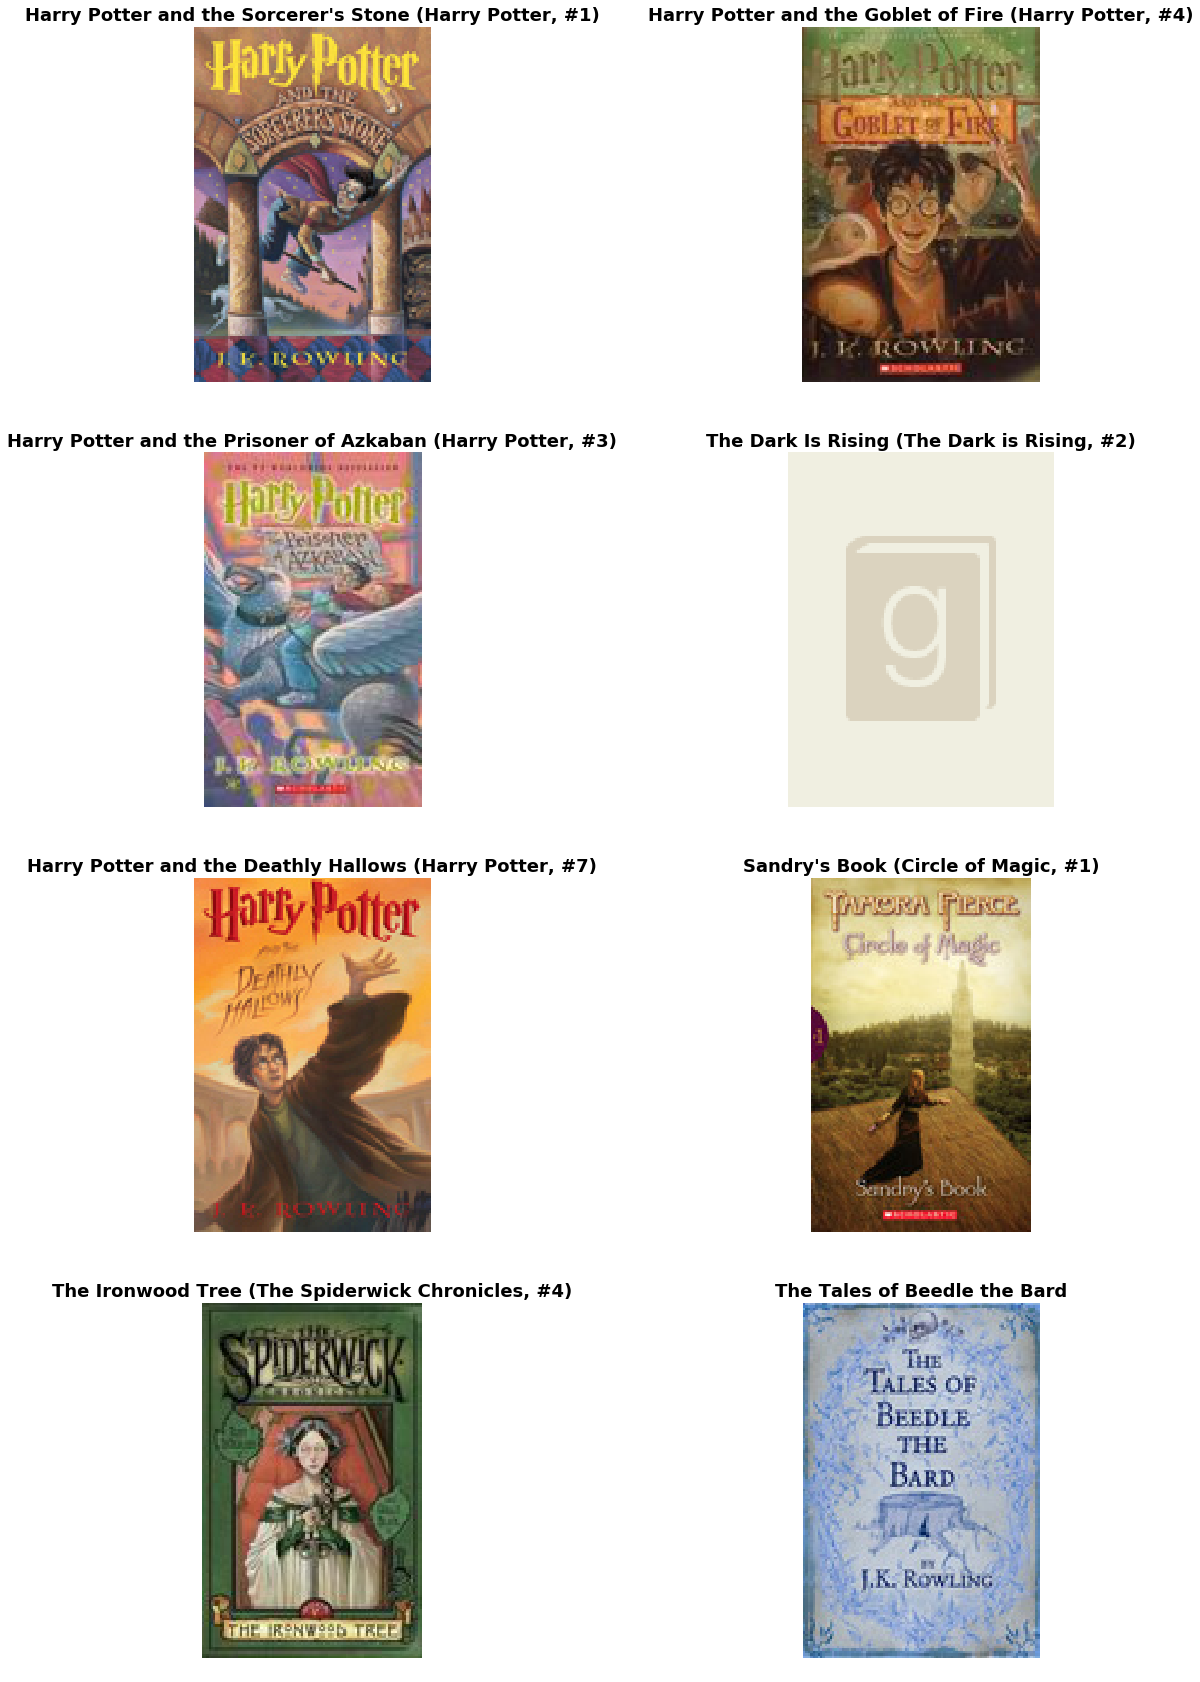

In [15]:
recommendation(select_list[4])

In [ ]:
ml_df = final_pivot.reset_index()

In [ ]:
ml_df = pd.merge(ml_df, books[['title', 'average_rating','work_ratings_count']],on = 'title', how='left')


In [ ]:
ml_df = ml_df[(ml_df['average_rating']>4.0) & (ml_df['work_ratings_count']>50000)]

In [ ]:
X = ml_df.drop(['title','average_rating','work_ratings_count','fiction','favorite'],axis=1).as_matrix()

In [ ]:
y = list(ml_df['title'])

In [ ]:
ml_df = ml_df.drop(['average_rating','work_ratings_count','fiction','favorite'],axis=1)

In [ ]:
# Import KMeans
from sklearn.cluster import KMeans

# Create a KMeans instance with 3 clusters: model
model = KMeans(n_clusters = 6)

# Fit model to points
model.fit(X)

# Determine the cluster labels of new_points: labels
labels = model.predict(X)
ml_df['labels'] = labels
ml_df['labels'] =ml_df['labels'].astype(str)
 

In [ ]:
# Import TSNE
from sklearn.manifold import TSNE

# Create a TSNE instance: model
model = TSNE(learning_rate = 100)

# Apply fit_transform to samples: tsne_features
tsne_features = model.fit_transform(X)

# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1st feature: ys
ys = tsne_features[:,1]

# Scatter plot, coloring by variety_numbers
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.scatter(xs, ys, c = labels,s=100)
for x, Y, book in zip(xs[:20], ys[:20], y[:20]):
    plt.annotate(book, (x, Y), fontsize=10, alpha=0.70)
plt.show()


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)

ml_df['pca-one'] = pca_result[:,0]
ml_df['pca-two'] = pca_result[:,1] 
ml_df['pca-three'] = pca_result[:,2]

In [ ]:
from ggplot import *
chart = ggplot(ml_df, aes(x='pca-one', y='pca-two',z='pca-three',color='labels',label='title')) \
        + geom_point(size=75,alpha=0.5) \
        + ggtitle("Clustered according to genres") 
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
chart

In [ ]:
 
# Plot initialisation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ml_df['pca-one'], ml_df['pca-two'], ml_df['pca-three'], c=ml_df['labels'], cmap="Dark2", s=60)
 
# make simple, bare axis lines through space:
xAxisLine = ((min(ml_df['pca-one']), max(ml_df['pca-one'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(ml_df['pca-two']), max(ml_df['pca-two'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(ml_df['pca-three']), max(ml_df['pca-three'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
frame1.axes.zaxis.set_ticklabels([])

fig = plt.gcf()
fig.set_size_inches(25, 25)
plt.savefig('Poster3',dpi=150)
plt.show()
